# I. Preparation

In [1]:
import os
import h5py
import time
import itertools

from math import log, sqrt
from statistics import stdev, variance, mean

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import signal
from scipy.stats import ttest_ind, ttest_1samp

import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.multicomp import pairwise_tukeyhsd

from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance

from fooof import FOOOF, FOOOFGroup
from fooof.plts.spectra import plot_spectrum, plot_spectrum_shading, plot_spectra, plot_spectra_shading
from fooof.analysis import get_band_peak_fm, get_band_peak_fg
from fooof.plts.periodic import plot_peak_fits, plot_peak_params
from fooof.plts.aperiodic import plot_aperiodic_params, plot_aperiodic_fits
from fooof.objs.utils import combine_fooofs

from neurodsp.filt import filter_signal
from neurodsp.utils import create_times
from neurodsp.plts.time_series import plot_time_series
from neurodsp.spectral import compute_spectrum

## 1. Function to read .mat files

In [2]:
def read_matlab(filename):
    def conv(path=''):
        p = path or '/'
        paths[p] = ret = {}
        for k, v in f[p].items():
            if type(v).__name__ == 'Group':
                ret[k] = conv(f'{path}/{k}')  # Nested struct
                continue
            v = v[()]  # It's a Numpy array now
            if v.dtype == 'object':
                # HDF5ObjectReferences are converted into a list of actual pointers
                ret[k] = [r and paths.get(f[r].name, f[r].name) for r in v.flat]
            else:
                # Matrices and other numeric arrays
                ret[k] = v if v.ndim < 2 else v.swapaxes(-1, -2)
        return ret

    paths = {}
    with h5py.File(filename, 'r') as f:
        return conv()

## 2. Parameters that can be changed

In [3]:
# Days
days = ('/Day1', '/Day2')

# Subjects
subjects = ['S1', 'S2', 'S3', 'S4', 'S5', 'S6', 'S7', 'S8', 'S9', 'S10', 
            'S11', 'S12', 'S13', 'S14', 'S15', 'S16', 'S17', 'S18', 'S19', 'S20', 
            'S21', 'S22', 'S23', 'S24', 'S25', 'S26', 'S27', 'S28', 'S29', 'S30']

In [4]:
# Parieto, parieto-occipital and occipital channels
channels = (17,18,19,20,21,22,23,24,25,26,27,29,30)
n_channels = 13

In [5]:
table = 2

# Frequency range to fit FOOOF model: Low, Mid, or High
fr = (3,20)

# Frequency range from which to collect Gaussians
bn = (3,9)

## 3. Parameters that should stay fixed

In [6]:
# Sampling rate
fs = 200

# nperseg
nperseg = 500

# Set peak_width_limits
pwl = [2, 4]

# Set max_n_peaks
mnp = 5

# Set peak_threshold
pt = 2 

# Initialize dataframe to store variables
df = pd.DataFrame([], index = [], columns = ['subject', 'day', 'target', \
                                             'offset', 'knee', 'exponent', \
                                             'CF', 'PW', 'BW', 'n_peaks', \
                                             'r_squared', 'error'])

# Colors
colors = ['blue', 'yellow', 'green', 'red']

# II. Fourier transform and FOOOF

S1 /Day1 cnt_HIGH(1).mat
S1 /Day1 cnt_HIGH(2).mat
S1 /Day1 cnt_LOW(1).mat
S1 /Day1 cnt_LOW(2).mat
S1 /Day1 cnt_MID(1).mat
S1 /Day1 cnt_MID(2).mat
S1 /Day2 cnt_HIGH(1).mat
S1 /Day2 cnt_HIGH(2).mat
S1 /Day2 cnt_LOW(1).mat
S1 /Day2 cnt_LOW(2).mat
S1 /Day2 cnt_MID(1).mat
S1 /Day2 cnt_MID(2).mat
S2 /Day1 cnt_HIGH(1).mat
S2 /Day1 cnt_HIGH(2).mat
S2 /Day1 cnt_LOW(1).mat
S2 /Day1 cnt_LOW(2).mat
S2 /Day1 cnt_MID(1).mat
S2 /Day1 cnt_MID(2).mat
S2 /Day2 cnt_HIGH(1).mat
S2 /Day2 cnt_HIGH(2).mat
S2 /Day2 cnt_LOW(1).mat
S2 /Day2 cnt_LOW(2).mat
S2 /Day2 cnt_MID(1).mat
S2 /Day2 cnt_MID(2).mat
S3 /Day1 cnt_HIGH(1).mat
S3 /Day1 cnt_HIGH(2).mat
S3 /Day1 cnt_LOW(1).mat
S3 /Day1 cnt_LOW(2).mat
S3 /Day1 cnt_MID(1).mat
S3 /Day1 cnt_MID(2).mat
S3 /Day2 cnt_HIGH(1).mat
S3 /Day2 cnt_HIGH(2).mat
S3 /Day2 cnt_LOW(1).mat
S3 /Day2 cnt_LOW(2).mat
S3 /Day2 cnt_MID(1).mat
S3 /Day2 cnt_MID(2).mat
S4 /Day1 cnt_HIGH(1).mat
S4 /Day1 cnt_HIGH(2).mat
S4 /Day1 cnt_LOW(1).mat
S4 /Day1 cnt_LOW(2).mat
S4 /Day1 cnt_MID(1).mat
S4

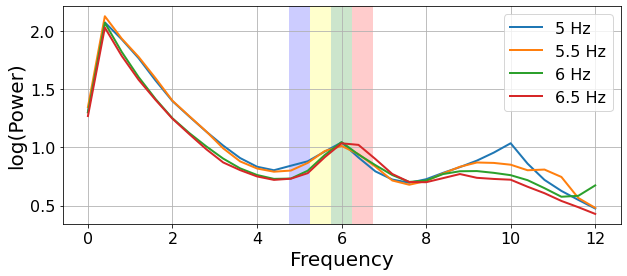

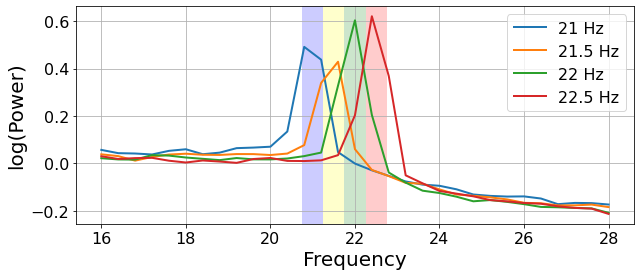

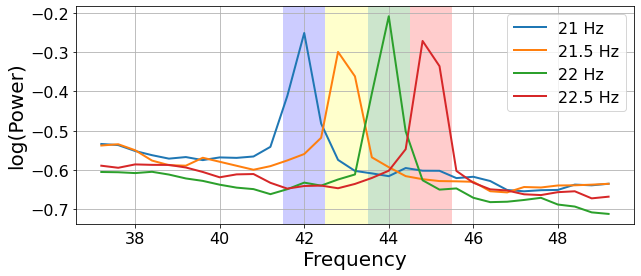

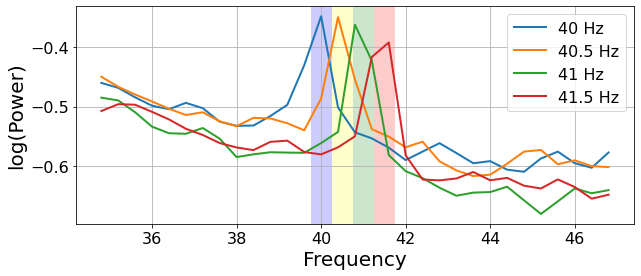

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     2.9520, 88.0664, 2.2940                                      
                                                                                                  
                                       2 peaks were found:                                        
          

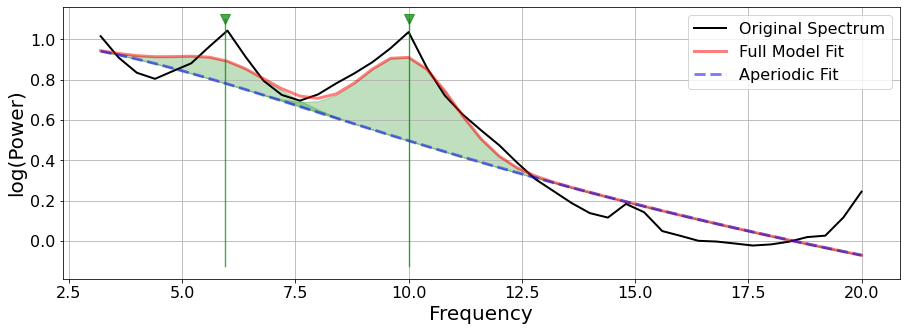

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.2380, 194.7699, 2.5396                                     
                                                                                                  
                                       3 peaks were found:                                        
          

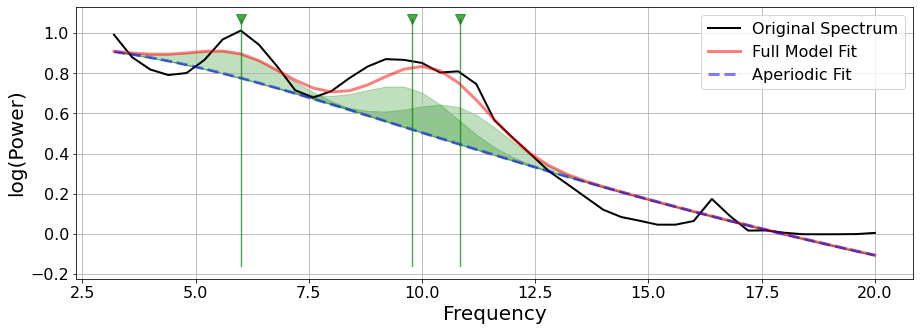

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    4.3046, 3127.5007, 3.5203                                     
                                                                                                  
                                       3 peaks were found:                                        
          

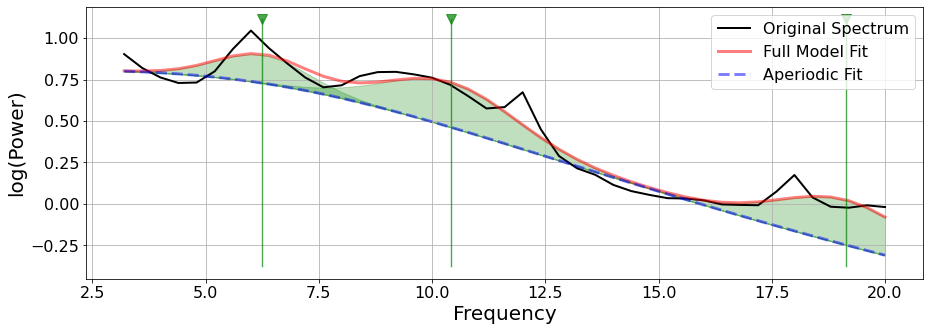

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.4398, 386.6978, 2.7129                                     
                                                                                                  
                                       2 peaks were found:                                        
          

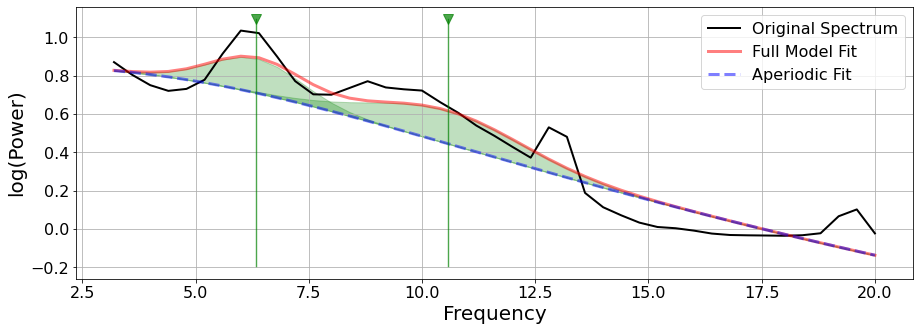

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.3044, 204.1117, 2.5707                                     
                                                                                                  
                                       2 peaks were found:                                        
          

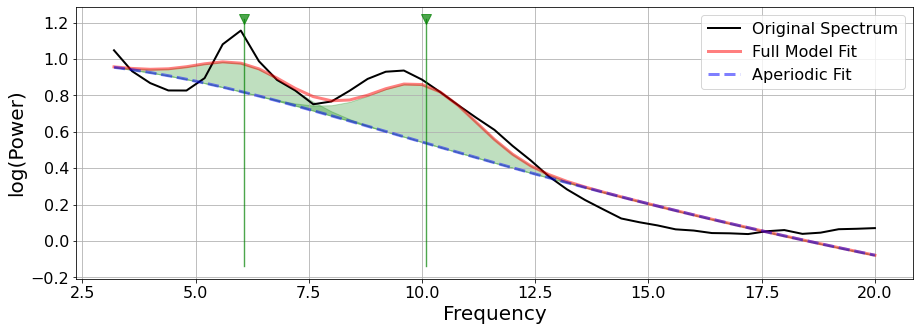

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.4516, 304.9925, 2.7027                                     
                                                                                                  
                                       2 peaks were found:                                        
          

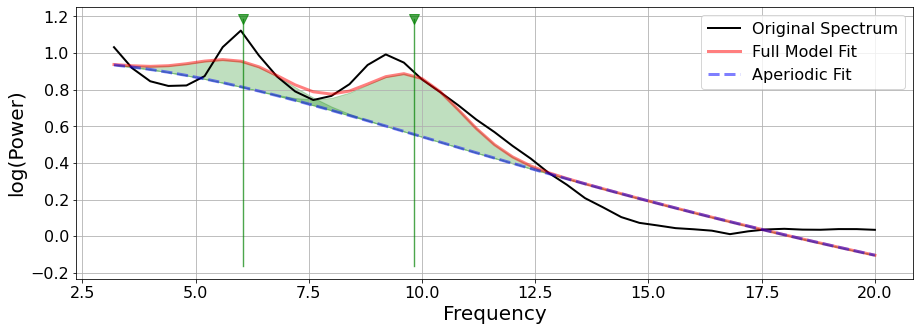

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.5367, 428.5550, 2.7802                                     
                                                                                                  
                                       2 peaks were found:                                        
          

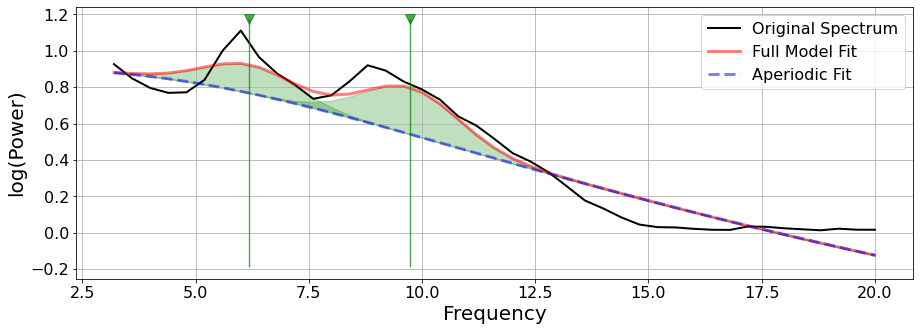

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.2773, 237.4455, 2.5731                                     
                                                                                                  
                                       2 peaks were found:                                        
          

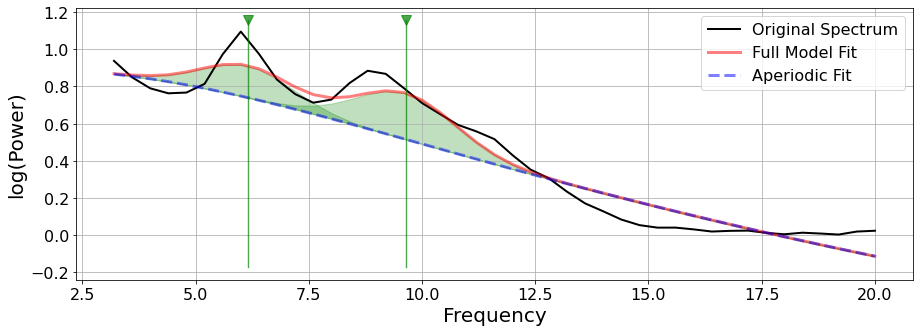

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.6567, 474.1156, 2.8629                                     
                                                                                                  
                                       2 peaks were found:                                        
          

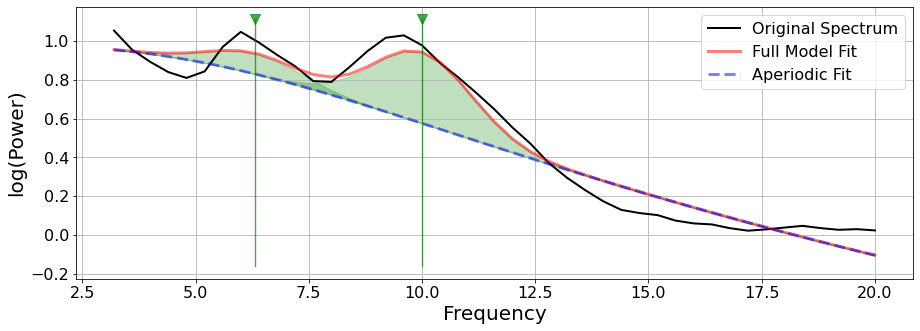

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.4519, 299.1248, 2.7043                                     
                                                                                                  
                                       2 peaks were found:                                        
          

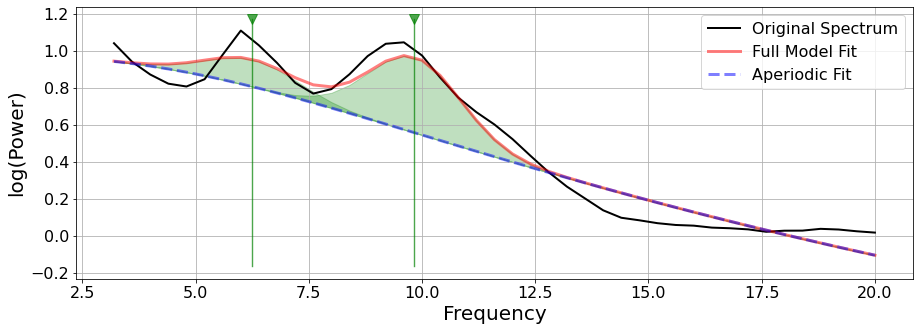

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.7043, 633.9320, 2.9152                                     
                                                                                                  
                                       2 peaks were found:                                        
          

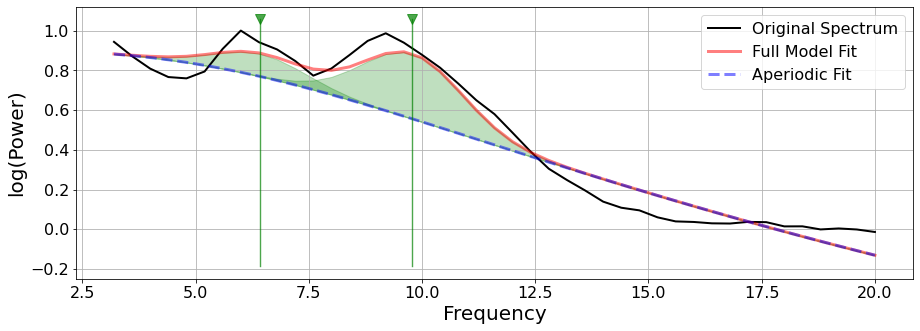

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.4847, 369.6495, 2.7386                                     
                                                                                                  
                                       2 peaks were found:                                        
          

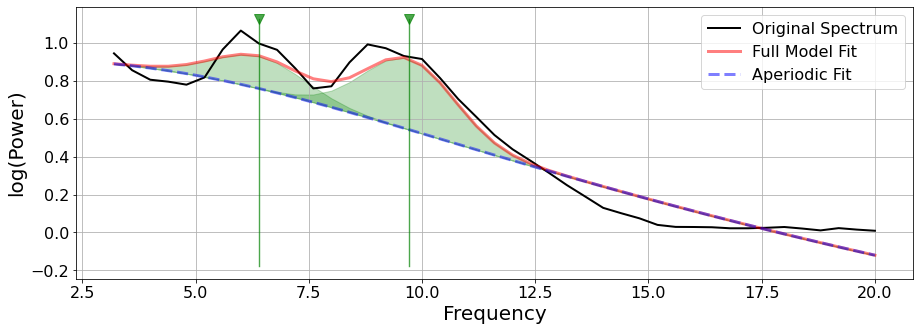

Done in 938.7386119365692 seconds


In [10]:
## Read EEG, calculate PSD (Welch), fit FOOOF

# Initialize array per target, grand average over subjects, days, trials and channels
total_powers_50 = np.empty((0, int(nperseg//2)+1), float)
total_powers_55 = np.empty((0, int(nperseg//2)+1), float)
total_powers_60 = np.empty((0, int(nperseg//2)+1), float)
total_powers_65 = np.empty((0, int(nperseg//2)+1), float)
total_powers_210 = np.empty((0, int(nperseg//2)+1), float)
total_powers_215 = np.empty((0, int(nperseg//2)+1), float)
total_powers_220 = np.empty((0, int(nperseg//2)+1), float)
total_powers_225 = np.empty((0, int(nperseg//2)+1), float)
total_powers_400 = np.empty((0, int(nperseg//2)+1), float)
total_powers_405 = np.empty((0, int(nperseg//2)+1), float)
total_powers_410 = np.empty((0, int(nperseg//2)+1), float)
total_powers_415 = np.empty((0, int(nperseg//2)+1), float)

tic = time.time()
for subject in subjects: 
    for day in days:

        # Change working directory
        original = os.getcwd()
        os.chdir("C:/Users/ThinkPad/Desktop/Thesis/Data/"+subject+day)

        # Giving directory name
        folderdir = 'C:/Users/ThinkPad/Desktop/Thesis/Data/'+subject+day

        # Giving file extensions
        ext = ('.mat')

        # Iterating over directory
        for path, dirc, files in os.walk(folderdir):
            for file in files:
                if file.endswith(ext) and file.startswith('cnt'):
                    print(subject, day, file)

                    # LOW, MID, or HIGH
                    level = file[4:-7]

                    # Session 1, or session 2
                    session = file[-6]

                    # Read data
                    data = read_matlab(file)['cnt']['x']

                    # Read timestamps 
                    timestamps = (read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['time'])[0]

                    # Read stimuli order
                    order_stimuli = read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['event']['desc']

                    for trial, timestamp in enumerate(timestamps): 
                        if trial%2 == False:
                            start = int(timestamp)
                        else:
                            stop = int(timestamp)

                            for channel in channels:
#                                 # Apply bandpass filter
#                                 data[:,channel] = filter_signal(data[:,channel], fs, 'bandpass', f_range=fr)

                                # Splice data according to timestamps
                                sig = data[:,channel][start:stop]
                                times = create_times(len(sig)/fs, fs)

#                                 # Plot EEG 
#                                 fig, ax = plt.subplots(figsize=[15, 5])
#                                 plot_time_series(times, sig, xlim=[0,len(sig)/fs], ax=ax)
#                                 plt.show()                                

                                # Welch FFT: calculate mean of spectrogram
                                freq, power = signal.welch(sig, fs, window='hann', average='mean', nperseg=nperseg,\
                                                          noverlap=450, detrend='constant')

                                # Append power to previous powers
                                if level=='LOW':
                                    if order_stimuli[trial-1]==[1.]: 
                                        total_powers_50 = np.append(total_powers_50, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        total_powers_55 = np.append(total_powers_55, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        total_powers_60 = np.append(total_powers_60, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        total_powers_65 = np.append(total_powers_65, power.reshape(1, len(freq)), axis=0)
                                elif level=='MID':
                                    if order_stimuli[trial-1]==[1.]: 
                                        total_powers_210 = np.append(total_powers_210, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        total_powers_215 = np.append(total_powers_215, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        total_powers_220 = np.append(total_powers_220, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        total_powers_225 = np.append(total_powers_225, power.reshape(1, len(freq)), axis=0)
                                elif level=='HIGH':
                                    if order_stimuli[trial-1]==[1.]: 
                                        total_powers_400 = np.append(total_powers_400, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        total_powers_405 = np.append(total_powers_405, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        total_powers_410 = np.append(total_powers_410, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        total_powers_415 = np.append(total_powers_415, power.reshape(1, len(freq)), axis=0)

## Grand average: Plot PSD averaged over powers per target
# LOW
fig, ax = plt.subplots(figsize=[10, 4])
plot_spectra_shading(freq[0:31], [np.mean(total_powers_50, axis=0)[0:31],\
                          np.mean(total_powers_55, axis=0)[0:31], \
                          np.mean(total_powers_60, axis=0)[0:31], \
                          np.mean(total_powers_65, axis=0)[0:31]], \
                     shades=[[4.75,5.25],[5.25,5.75],[5.75,6.25],[6.25,6.75]], \
                     labels=['5 Hz', '5.5 Hz', '6 Hz', '6.5 Hz'],\
                     log_powers=True, alpha=1, shade_colors=colors, ax=ax)
plt.show()

# MID
fig, ax = plt.subplots(figsize=[10, 4])
plot_spectra_shading(freq[40:71], [np.mean(total_powers_210, axis=0)[40:71],\
                          np.mean(total_powers_215, axis=0)[40:71], \
                          np.mean(total_powers_220, axis=0)[40:71], \
                          np.mean(total_powers_225, axis=0)[40:71]], \
                     shades=[[20.75,21.25],[21.25,21.75],[21.75,22.25],[22.25,22.75]], \
                     labels=['21 Hz', '21.5 Hz', '22 Hz', '22.5 Hz'],\
                     log_powers=True, alpha=1, shade_colors=colors, ax=ax)
plt.show()

# MID second order harmonics
fig, ax = plt.subplots(figsize=[10, 4])
plot_spectra_shading(freq[93:124], [np.mean(total_powers_210, axis=0)[93:124],\
                          np.mean(total_powers_215, axis=0)[93:124], \
                          np.mean(total_powers_220, axis=0)[93:124], \
                          np.mean(total_powers_225, axis=0)[93:124]], \
                     shades=[[41.5,42.5],[42.5,43.5],[43.5,44.5],[44.5,45.5]], \
                     labels=['21 Hz', '21.5 Hz', '22 Hz', '22.5 Hz'],\
                     log_powers=True, alpha=1, shade_colors=colors, ax=ax)
plt.show()

# HIGH
fig, ax = plt.subplots(figsize=[10, 4])
plot_spectra_shading(freq[87:118], [np.mean(total_powers_400, axis=0)[87:118],\
                          np.mean(total_powers_405, axis=0)[87:118], \
                          np.mean(total_powers_410, axis=0)[87:118], \
                          np.mean(total_powers_415, axis=0)[87:118]], \
                     shades=[[39.75,40.25],[40.25,40.75],[40.75,41.25],[41.25,41.75]], \
                     labels=['40 Hz', '40.5 Hz', '41 Hz', '41.5 Hz'],\
                     log_powers=True, alpha=1, shade_colors=colors, ax=ax)
plt.show()

# Grand average FOOOF object: initialize, fit and print results
# LOW
for powers in (total_powers_50, total_powers_55, total_powers_60, total_powers_65):
    fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
    fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
    fm.print_results()
    fig, ax = plt.subplots(figsize=[15, 5])
    fm.plot(plot_peaks='line-shade', ax=ax)
    plt.show()

# MID
for powers in (total_powers_210, total_powers_215, total_powers_220, total_powers_225):
    fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
    fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
    fm.print_results()
    fig, ax = plt.subplots(figsize=[15, 5])
    fm.plot(plot_peaks='line-shade', ax=ax)
    plt.show()

# HIGH
for powers in (total_powers_400, total_powers_405, total_powers_410, total_powers_415):
    fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
    fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
    fm.print_results()
    fig, ax = plt.subplots(figsize=[15, 5])
    fm.plot(plot_peaks='line-shade', ax=ax)
    plt.show()

# Typecast dataframe
df[['subject', 'day', 'target']] = df[['subject', 'day', 'target']].astype('category')
df['n_peaks'] = df['n_peaks'].astype('int32')
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']] = \
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']].astype('float32')

# Change working directory back
os.chdir(original)

print(f'Done in {time.time()-tic} seconds')

# Same for 3 channels
# I. Preparation

In [11]:
# Occipital channels
channels = (23,24,25) 
n_channels = 3

# II. Fourier transform and FOOOF

S1 /Day1 cnt_HIGH(1).mat
S1 /Day1 cnt_HIGH(2).mat
S1 /Day1 cnt_LOW(1).mat
S1 /Day1 cnt_LOW(2).mat
S1 /Day1 cnt_MID(1).mat
S1 /Day1 cnt_MID(2).mat
S1 /Day2 cnt_HIGH(1).mat
S1 /Day2 cnt_HIGH(2).mat
S1 /Day2 cnt_LOW(1).mat
S1 /Day2 cnt_LOW(2).mat
S1 /Day2 cnt_MID(1).mat
S1 /Day2 cnt_MID(2).mat
S2 /Day1 cnt_HIGH(1).mat
S2 /Day1 cnt_HIGH(2).mat
S2 /Day1 cnt_LOW(1).mat
S2 /Day1 cnt_LOW(2).mat
S2 /Day1 cnt_MID(1).mat
S2 /Day1 cnt_MID(2).mat
S2 /Day2 cnt_HIGH(1).mat
S2 /Day2 cnt_HIGH(2).mat
S2 /Day2 cnt_LOW(1).mat
S2 /Day2 cnt_LOW(2).mat
S2 /Day2 cnt_MID(1).mat
S2 /Day2 cnt_MID(2).mat
S3 /Day1 cnt_HIGH(1).mat
S3 /Day1 cnt_HIGH(2).mat
S3 /Day1 cnt_LOW(1).mat
S3 /Day1 cnt_LOW(2).mat
S3 /Day1 cnt_MID(1).mat
S3 /Day1 cnt_MID(2).mat
S3 /Day2 cnt_HIGH(1).mat
S3 /Day2 cnt_HIGH(2).mat
S3 /Day2 cnt_LOW(1).mat
S3 /Day2 cnt_LOW(2).mat
S3 /Day2 cnt_MID(1).mat
S3 /Day2 cnt_MID(2).mat
S4 /Day1 cnt_HIGH(1).mat
S4 /Day1 cnt_HIGH(2).mat
S4 /Day1 cnt_LOW(1).mat
S4 /Day1 cnt_LOW(2).mat
S4 /Day1 cnt_MID(1).mat
S4

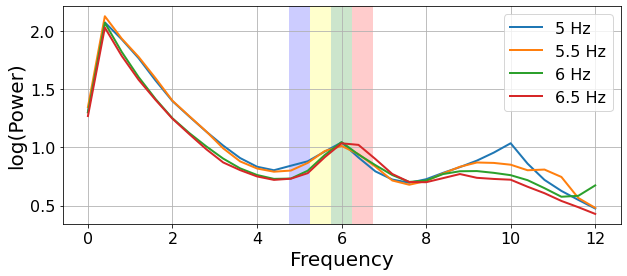

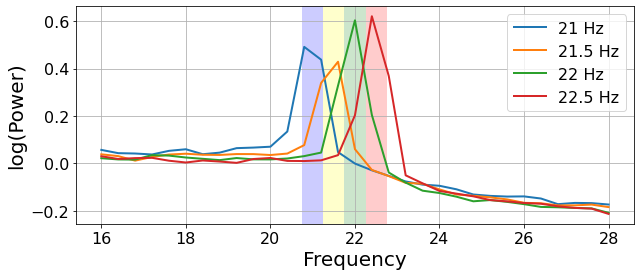

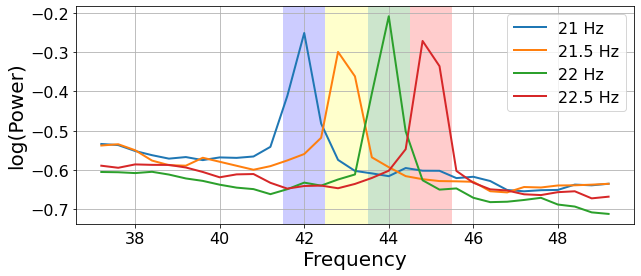

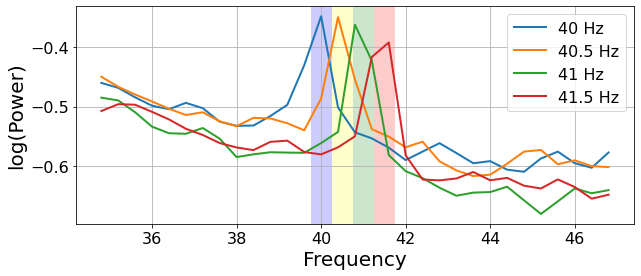

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     2.9520, 88.0664, 2.2940                                      
                                                                                                  
                                       2 peaks were found:                                        
          

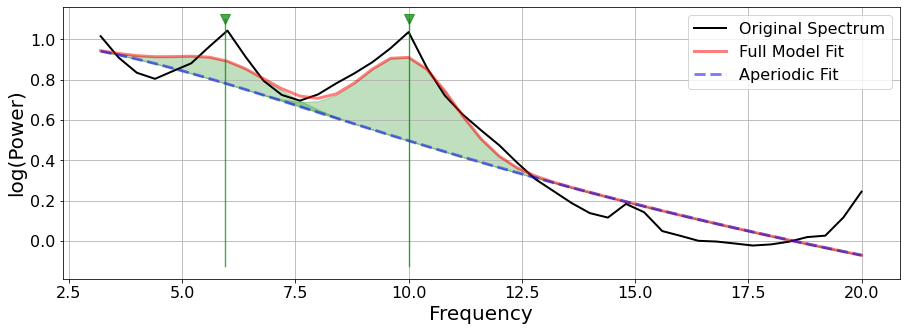

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.2380, 194.7699, 2.5396                                     
                                                                                                  
                                       3 peaks were found:                                        
          

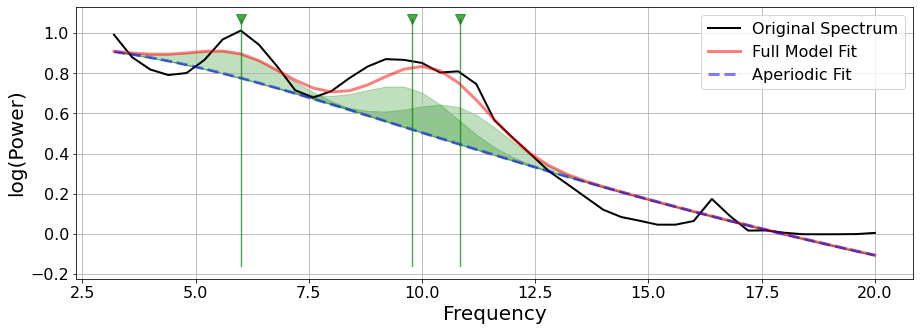

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                    4.3046, 3127.5007, 3.5203                                     
                                                                                                  
                                       3 peaks were found:                                        
          

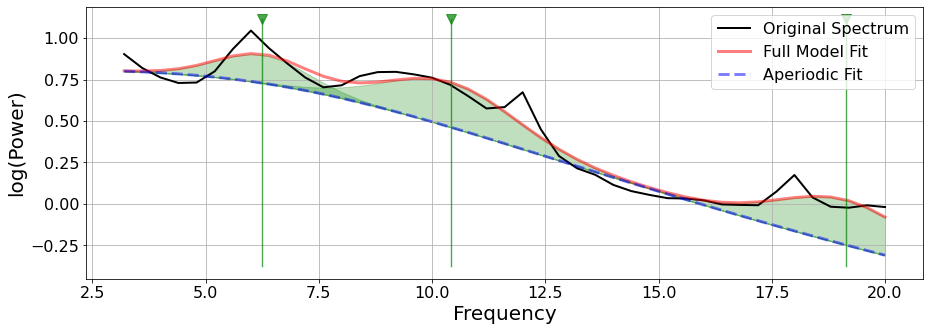

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.4398, 386.6978, 2.7129                                     
                                                                                                  
                                       2 peaks were found:                                        
          

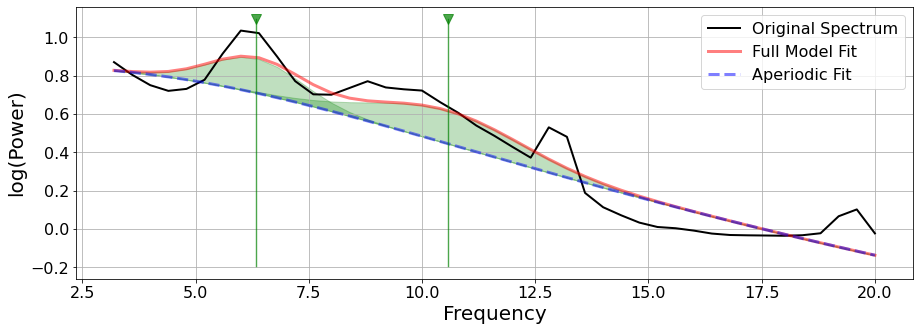

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.3044, 204.1117, 2.5707                                     
                                                                                                  
                                       2 peaks were found:                                        
          

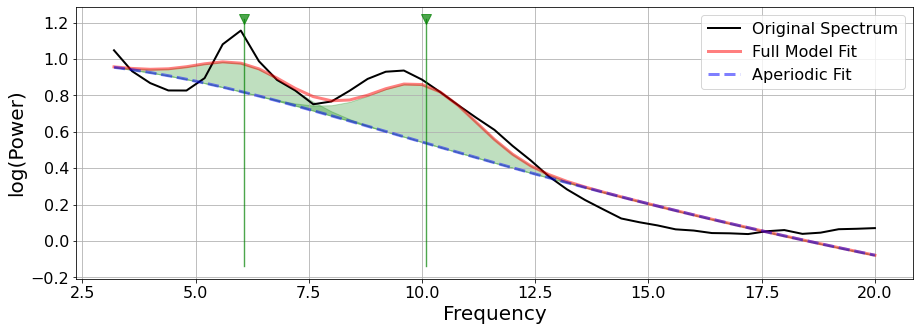

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.4516, 304.9925, 2.7027                                     
                                                                                                  
                                       2 peaks were found:                                        
          

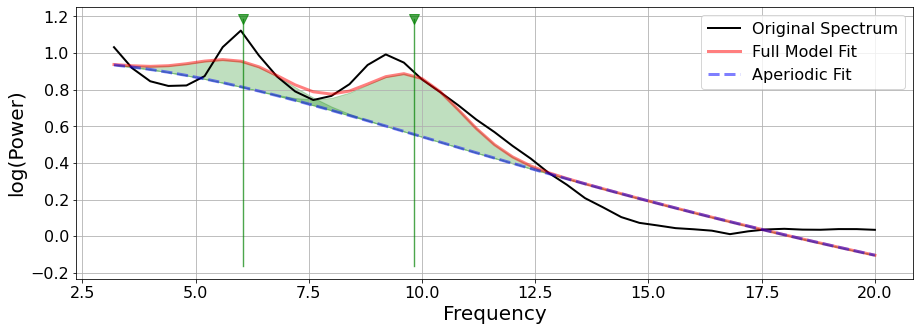

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.5367, 428.5550, 2.7802                                     
                                                                                                  
                                       2 peaks were found:                                        
          

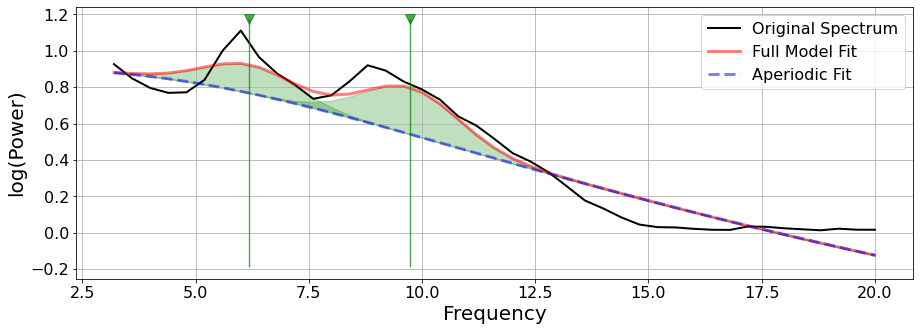

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.2773, 237.4455, 2.5731                                     
                                                                                                  
                                       2 peaks were found:                                        
          

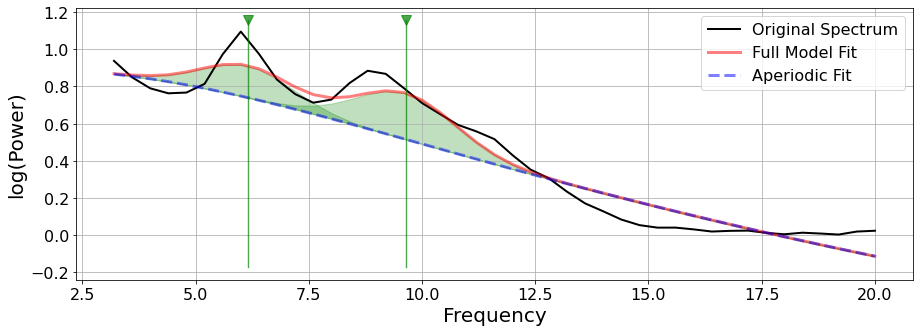

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.6567, 474.1156, 2.8629                                     
                                                                                                  
                                       2 peaks were found:                                        
          

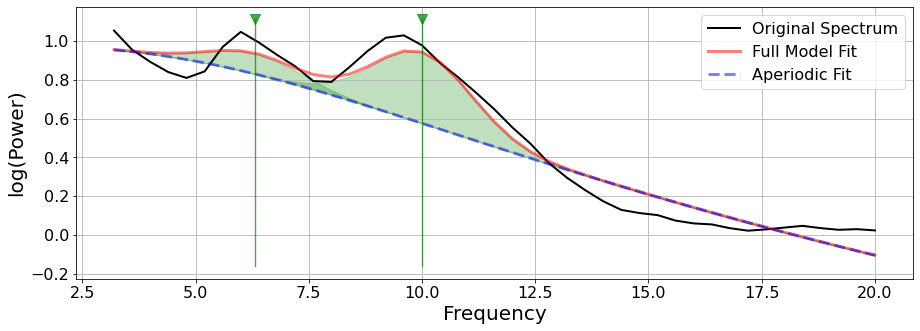

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.4519, 299.1248, 2.7043                                     
                                                                                                  
                                       2 peaks were found:                                        
          

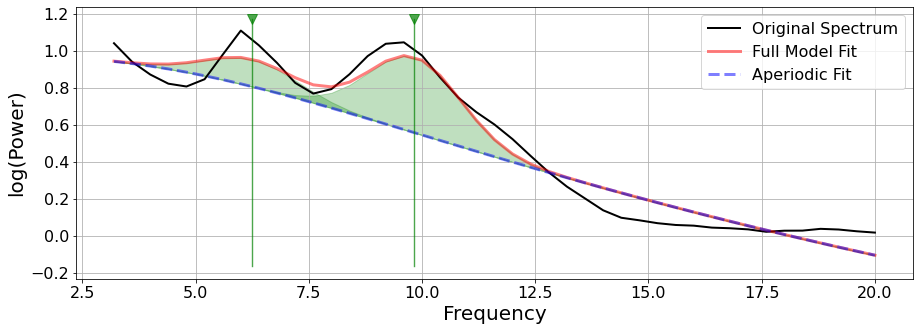

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.7043, 633.9320, 2.9152                                     
                                                                                                  
                                       2 peaks were found:                                        
          

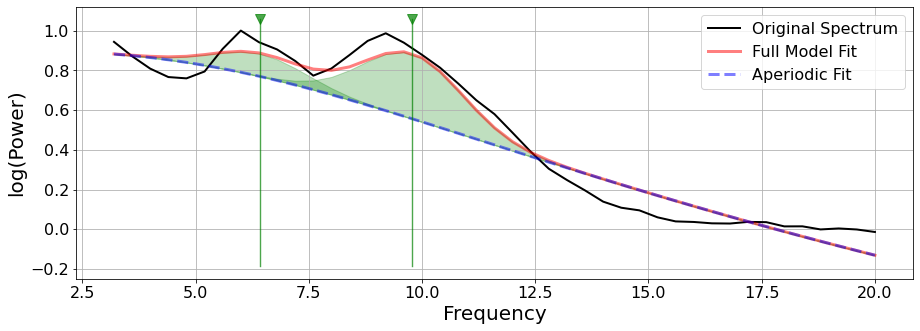

                                                                                                  
                                   FOOOF - POWER SPECTRUM MODEL                                   
                                                                                                  
                        The model was run on the frequency range 3 - 20 Hz                        
                                 Frequency Resolution is 0.40 Hz                                  
                                                                                                  
                         Aperiodic Parameters (offset, knee, exponent):                           
                                     3.4847, 369.6495, 2.7386                                     
                                                                                                  
                                       2 peaks were found:                                        
          

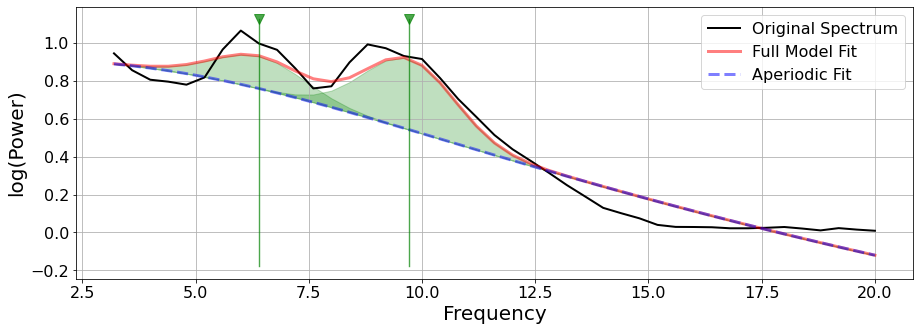

Done in 871.1501169204712 seconds


In [12]:
## Read EEG, calculate PSD (Welch), fit FOOOF

# Initialize array per target, grand average over subjects, days, trials and channels
total_powers_50 = np.empty((0, int(nperseg//2)+1), float)
total_powers_55 = np.empty((0, int(nperseg//2)+1), float)
total_powers_60 = np.empty((0, int(nperseg//2)+1), float)
total_powers_65 = np.empty((0, int(nperseg//2)+1), float)
total_powers_210 = np.empty((0, int(nperseg//2)+1), float)
total_powers_215 = np.empty((0, int(nperseg//2)+1), float)
total_powers_220 = np.empty((0, int(nperseg//2)+1), float)
total_powers_225 = np.empty((0, int(nperseg//2)+1), float)
total_powers_400 = np.empty((0, int(nperseg//2)+1), float)
total_powers_405 = np.empty((0, int(nperseg//2)+1), float)
total_powers_410 = np.empty((0, int(nperseg//2)+1), float)
total_powers_415 = np.empty((0, int(nperseg//2)+1), float)

tic = time.time()
for subject in subjects: 
    for day in days:

        # Change working directory
        original = os.getcwd()
        os.chdir("C:/Users/ThinkPad/Desktop/Thesis/Data/"+subject+day)

        # Giving directory name
        folderdir = 'C:/Users/ThinkPad/Desktop/Thesis/Data/'+subject+day

        # Giving file extensions
        ext = ('.mat')

        # Iterating over directory
        for path, dirc, files in os.walk(folderdir):
            for file in files:
                if file.endswith(ext) and file.startswith('cnt'):
                    print(subject, day, file)

                    # LOW, MID, or HIGH
                    level = file[4:-7]

                    # Session 1, or session 2
                    session = file[-6]

                    # Read data
                    data = read_matlab(file)['cnt']['x']

                    # Read timestamps 
                    timestamps = (read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['time'])[0]

                    # Read stimuli order
                    order_stimuli = read_matlab(folderdir+'/mrk_'+level+'('+session+').mat')['mrk']['event']['desc']

                    for trial, timestamp in enumerate(timestamps):   
                        if trial%2 == False:
                            start = int(timestamp)
                        else:
                            stop = int(timestamp)

                            for channel in channels:
#                                 # Apply bandpass filter
#                                 data[:,channel] = filter_signal(data[:,channel], fs, 'bandpass', f_range=fr)

                                # Splice data according to timestamps
                                sig = data[:,channel][start:stop]
                                times = create_times(len(sig)/fs, fs)

#                                 # Plot EEG 
#                                 fig, ax = plt.subplots(figsize=[15, 5])
#                                 plot_time_series(times, sig, xlim=[0,len(sig)/fs], ax=ax)
#                                 plt.show()                                

                                # Welch FFT: calculate mean of spectrogram
                                freq, power = signal.welch(sig, fs, window='hann', average='mean', nperseg=nperseg,\
                                                          noverlap=450, detrend='constant')

                                # Append power to previous powers
                                if level=='LOW':
                                    if order_stimuli[trial-1]==[1.]: 
                                        total_powers_50 = np.append(total_powers_50, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        total_powers_55 = np.append(total_powers_55, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        total_powers_60 = np.append(total_powers_60, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        total_powers_65 = np.append(total_powers_65, power.reshape(1, len(freq)), axis=0)
                                elif level=='MID':
                                    if order_stimuli[trial-1]==[1.]: 
                                        total_powers_210 = np.append(total_powers_210, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        total_powers_215 = np.append(total_powers_215, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        total_powers_220 = np.append(total_powers_220, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        total_powers_225 = np.append(total_powers_225, power.reshape(1, len(freq)), axis=0)
                                elif level=='HIGH':
                                    if order_stimuli[trial-1]==[1.]: 
                                        total_powers_400 = np.append(total_powers_400, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[2.]: 
                                        total_powers_405 = np.append(total_powers_405, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[3.]: 
                                        total_powers_410 = np.append(total_powers_410, power.reshape(1, len(freq)), axis=0)
                                    elif order_stimuli[trial-1]==[4.]: 
                                        total_powers_415 = np.append(total_powers_415, power.reshape(1, len(freq)), axis=0)
            
## Grand average: Plot PSD averaged over powers per target
# LOW
fig, ax = plt.subplots(figsize=[10, 4])
plot_spectra_shading(freq[0:31], [np.mean(total_powers_50, axis=0)[0:31],\
                          np.mean(total_powers_55, axis=0)[0:31], \
                          np.mean(total_powers_60, axis=0)[0:31], \
                          np.mean(total_powers_65, axis=0)[0:31]], \
                     shades=[[4.75,5.25],[5.25,5.75],[5.75,6.25],[6.25,6.75]], \
                     labels=['5 Hz', '5.5 Hz', '6 Hz', '6.5 Hz'],\
                     log_powers=True, alpha=1, shade_colors=colors, ax=ax)
plt.show()

#  MID
fig, ax = plt.subplots(figsize=[10, 4])
plot_spectra_shading(freq[40:71], [np.mean(total_powers_210, axis=0)[40:71],\
                          np.mean(total_powers_215, axis=0)[40:71], \
                          np.mean(total_powers_220, axis=0)[40:71], \
                          np.mean(total_powers_225, axis=0)[40:71]], \
                     shades=[[20.75,21.25],[21.25,21.75],[21.75,22.25],[22.25,22.75]], \
                     labels=['21 Hz', '21.5 Hz', '22 Hz', '22.5 Hz'],\
                     log_powers=True, alpha=1, shade_colors=colors, ax=ax)
plt.show()

# MID second order harmonics
fig, ax = plt.subplots(figsize=[10, 4])
plot_spectra_shading(freq[93:124], [np.mean(total_powers_210, axis=0)[93:124],\
                          np.mean(total_powers_215, axis=0)[93:124], \
                          np.mean(total_powers_220, axis=0)[93:124], \
                          np.mean(total_powers_225, axis=0)[93:124]], \
                     shades=[[41.5,42.5],[42.5,43.5],[43.5,44.5],[44.5,45.5]], \
                     labels=['21 Hz', '21.5 Hz', '22 Hz', '22.5 Hz'],\
                     log_powers=True, alpha=1, shade_colors=colors, ax=ax)
plt.show()

# HIGH
fig, ax = plt.subplots(figsize=[10, 4])
plot_spectra_shading(freq[87:118], [np.mean(total_powers_400, axis=0)[87:118],\
                          np.mean(total_powers_405, axis=0)[87:118], \
                          np.mean(total_powers_410, axis=0)[87:118], \
                          np.mean(total_powers_415, axis=0)[87:118]], \
                     shades=[[39.75,40.25],[40.25,40.75],[40.75,41.25],[41.25,41.75]], \
                     labels=['40 Hz', '40.5 Hz', '41 Hz', '41.5 Hz'],\
                     log_powers=True, alpha=1, shade_colors=colors, ax=ax)
plt.show()

# Grand average FOOOF object: initialize, fit and print results
# LOW
for powers in (total_powers_50, total_powers_55, total_powers_60, total_powers_65):
    fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
    fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
    fm.print_results()
    fig, ax = plt.subplots(figsize=[15, 5])
    fm.plot(plot_peaks='line-shade', ax=ax)
    plt.show()

# MID
for powers in (total_powers_210, total_powers_215, total_powers_220, total_powers_225):
    fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
    fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
    fm.print_results()
    fig, ax = plt.subplots(figsize=[15, 5])
    fm.plot(plot_peaks='line-shade', ax=ax)
    plt.show()

# HIGH
for powers in (total_powers_400, total_powers_405, total_powers_410, total_powers_415):
    fm = FOOOF(aperiodic_mode='knee', peak_width_limits=pwl, max_n_peaks=mnp, peak_threshold=pt, verbose=True)
    fm.fit(freq, np.mean(powers, axis=0), freq_range=fr)
    fm.print_results()
    fig, ax = plt.subplots(figsize=[15, 5])
    fm.plot(plot_peaks='line-shade', ax=ax)
    plt.show()

# Typecast dataframe
df[['subject', 'day', 'target']] = df[['subject', 'day', 'target']].astype('category')
df['n_peaks'] = df['n_peaks'].astype('int32')
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']] = \
df[['offset', 'knee', 'exponent', 'CF', 'PW', 'BW', 'r_squared', 'error']].astype('float32')

# Change working directory back
os.chdir(original)

print(f'Done in {time.time()-tic} seconds')